In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical  # Only for categorical one hot encoding
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
cy_train = np.array(to_categorical(y_train))
cy_test = np.array(to_categorical(y_test))

cx_train, cx_test = np.array((x_train.reshape(x_train.shape[0], 28, 28, 1) - 127.5)/127.5), np.array((x_test.reshape(x_test.shape[0], 28, 28, 1)-127.5)/127.5)
cx_train.shape

(60000, 28, 28, 1)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

def discriminator_loss(real_output, fake_output, smooth=1):
    real_loss = cross_entropy(tf.ones_like(real_output) * smooth, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = tf.concat((fake_loss, real_loss), axis=0)
    # total_loss = (fake_loss + real_loss) * 0.5
    return total_loss #* 0.5
    
def wasserstein_discriminator_loss(real_output, fake_output):
    total_loss = -tf.reduce_mean(real_output - fake_output)
    return total_loss

def generator_loss(fake_output, smooth=1):
    return cross_entropy(tf.ones_like(fake_output) * smooth, fake_output)

def wasserstein_generator_loss(fake_output):
    total_loss = -tf.reduce_mean(fake_output)
    return total_loss

def generator_enc_loss(real, fake):
  # return tf.reduce_mean(tf.abs(real - fake))
  return tf.keras.losses.mean_absolute_error(real, fake)

In [ ]:
def generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(512, use_bias=False, input_shape=(128,)))
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (7, 7), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (7, 7), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def discriminator():
    inputLayer = layers.Input((28, 28, 1))
    x = tf.keras.layers.GaussianNoise(0.01)(inputLayer)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    # x = layers.Dropout(0.3)(x)
    print(x.shape)
    x = layers.GlobalAveragePooling2D()(x)
    encOut = x

    clsOut = layers.Dense(10)(x)
    x = layers.Dense(1)(x)

    dis = tf.keras.models.Model(inputs=inputLayer, outputs=x)
    enc = tf.keras.models.Model(inputs=inputLayer, outputs=encOut)
    cls = tf.keras.models.Model(inputs=inputLayer, outputs=clsOut)

    return dis, enc, cls

In [ ]:
gen = generator()
des, enc, cls = discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

(None, 4, 4, 128)


In [ ]:
def trainDesGenEnc(gen, des, enc, real, batch_size):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    noise = enc(real, training=False)
    fake = gen(noise, training=True)
    X = tf.concat((fake, real), axis=0)
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

    gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainGenEnc(gen, enc, real, batch_size):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    real_enc = enc(real, training=False)
    enc_fake = gen(real_enc, training=True)

    gen_loss = generator_enc_loss(real, enc_fake) * 0.5
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainDes(gen, des, real, batch_size, smooth):
  with tf.GradientTape() as disc_tape:
    noise = tf.random.normal([batch_size, 128])

    fake = gen(noise, training=False)

    X = tf.concat((fake, real), axis=0)
    
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output, smooth)
    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

# @tf.function
def trainDesGen(gen, des, real, batch_size, smooth):
  with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
    noise = tf.random.normal([batch_size, 128])
    fake = gen(noise, training=True)
    X = tf.concat((fake, real), axis=0)
    pred = des(X, training=True)

    fake_output = pred[:batch_size]
    real_output = pred[batch_size:]

    des_loss = discriminator_loss(real_output, fake_output, smooth)
    gen_loss = generator_loss(fake_output, smooth)

    gradients_of_discriminator = disc_tape.gradient(des_loss, des.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, des.trainable_variables))

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

# @tf.function
def trainGen(gen, des, batch_size, smooth):
  with tf.GradientTape() as gen_tape:
    noise = tf.random.normal([batch_size, 128])

    fake = gen(noise, training=True)
    fake_output = des(fake, training=False)

    gen_loss = generator_loss(fake_output, smooth)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

def evalGan(gen, des, data, batches, batch_size):
  desAcc = 0
  genLoss = 0
  for i in range(batches):
    real = data[i]
    fake = gen.predict(tf.random.normal([batch_size, 128]))
    X = tf.concat((fake, real), axis=0)

    output = des.predict(X)

    real_output = output[batch_size:]
    fake_output = output[:batch_size]

    labels = tf.reshape(tf.concat((tf.zeros_like(fake_output), tf.ones_like(real_output)), axis=0), [-1])
    output = tf.reshape(output, [-1])
    
    acc = tf.keras.metrics.binary_accuracy(labels, output, threshold=0.5)
    desAcc += acc.numpy()
    # print(acc)
    genLoss += tf.reduce_sum(generator_loss(fake_output)).numpy() / batch_size
  return desAcc / batches, genLoss / batches

def trainGan(realData, labels=None, epochs=10, batch_size=5, loss='mse', smooth=1.):
  realData = np.array(realData).reshape(tuple([-1, batch_size] + list(realData.shape[1:])))
  labels = np.array(labels).reshape(tuple([-1, batch_size] + list(labels.shape[1:])))
  print(realData.shape)
  noise = tf.random.normal([16, 128])
  results = []
  for epoch in range(epochs):
    realData = tf.random.shuffle(realData)
    for iter in range(len(realData)):
      real = realData[iter]
      real = tf.cast(real, tf.float32)

      trainDes(gen, des, real, batch_size, smooth)
      trainGen(gen, des, batch_size, smooth)
      # trainDesGen(gen, des, real, batch_size, smooth)
      # trainGenEnc(gen, enc, real, batch_size)
      # trainDesGenEnc(gen, des, enc, real, batch_size)

    fake = gen.predict(noise)
    print("Evaluating:")
    desAcc, genLoss = evalGan(gen, des, realData, 10, batch_size)
    results.append({'desAcc':desAcc, 'genLoss':genLoss})
    print("Epoch ", epoch, desAcc, genLoss)

    fig = plt.figure(figsize=(4,4))

    for i in range(fake.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(fake[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

(1000, 60, 28, 28, 1)
Evaluating:
Epoch  0 0.9074999928474426 4.559733963012695


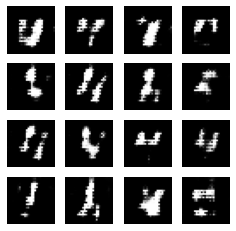

Evaluating:
Epoch  1 0.914166659116745 2.8120905049641927


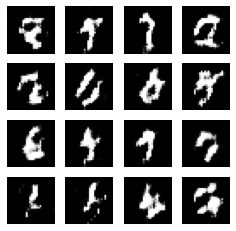

Evaluating:
Epoch  2 0.8208333432674408 1.988793830871582


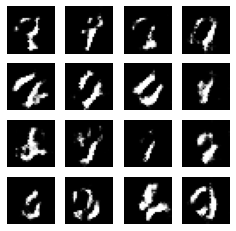

Evaluating:
Epoch  3 0.8083333432674408 1.1137739562988282


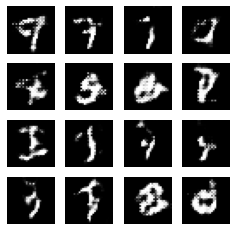

Evaluating:
Epoch  4 0.7583333373069763 1.8462065251668296


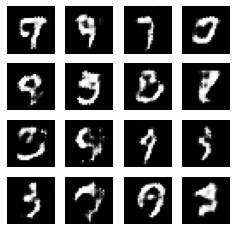

Evaluating:
Epoch  5 0.8383333325386048 1.4111011759440104


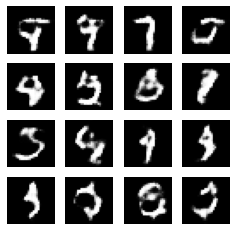

Evaluating:
Epoch  6 0.7300000011920929 1.796614316304525


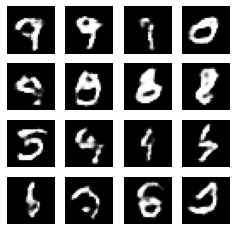

Evaluating:
Epoch  7 0.7149999916553498 2.109949951171875


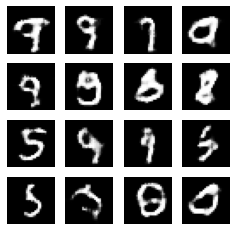

Evaluating:
Epoch  8 0.7583333313465118 2.2350515238444015


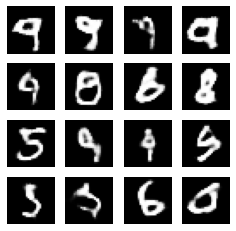

Evaluating:
Epoch  9 0.7416666626930237 0.703263734181722


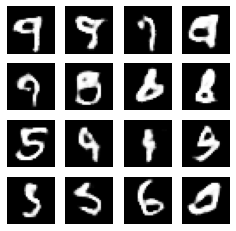

Evaluating:
Epoch  10 0.865833330154419 1.5646040725708006


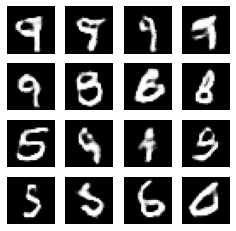

Evaluating:
Epoch  11 0.8366666734218597 1.129976272583008


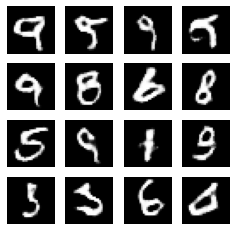

Evaluating:
Epoch  12 0.7666666686534882 1.5155182520548505


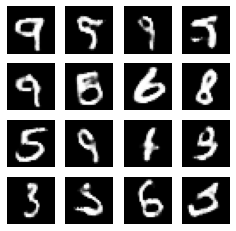

Evaluating:
Epoch  13 0.8549999952316284 1.4070952860514325


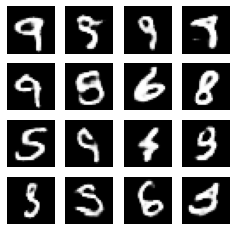

Evaluating:
Epoch  14 0.7758333325386048 1.162263469696045


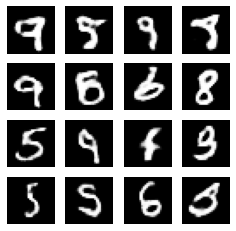

Evaluating:
Epoch  15 0.8033333241939544 0.938641300201416


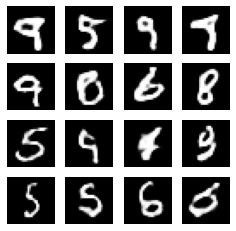

Evaluating:
Epoch  16 0.8591666698455811 1.5257744216918945


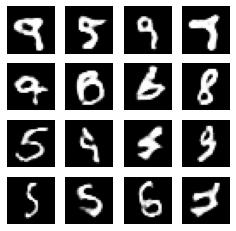

Evaluating:
Epoch  17 0.6716666698455811 0.5955727163950603


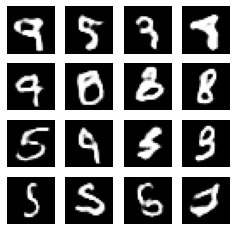

Evaluating:
Epoch  18 0.8133333384990692 1.3948887761433921


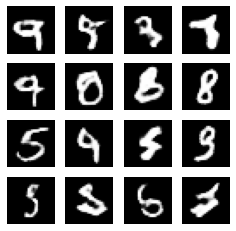

Evaluating:
Epoch  19 0.7341666698455811 0.7511497815450032


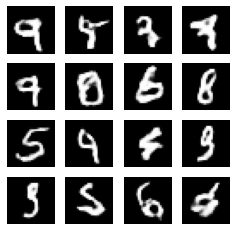

Evaluating:
Epoch  20 0.848333340883255 1.7111503601074216


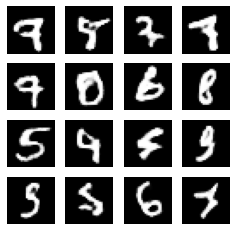

Evaluating:
Epoch  21 0.5908333241939545 0.2914440139134725


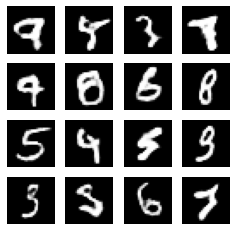

Evaluating:
Epoch  22 0.5208333253860473 0.09222384810447694


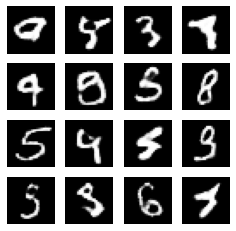

Evaluating:
Epoch  23 0.7474999964237213 2.7424476877848307


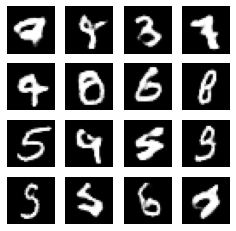

Evaluating:
Epoch  24 0.8008333325386048 2.375121358235677


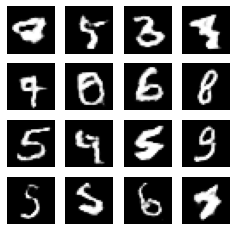

Evaluating:
Epoch  25 0.553333330154419 5.4137995910644525


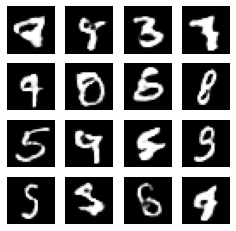

Evaluating:
Epoch  26 0.8375 2.009557317097982


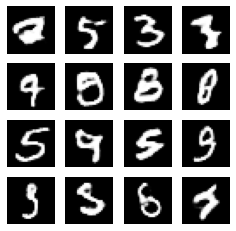

Evaluating:
Epoch  27 0.6675000071525574 0.5793411699930828


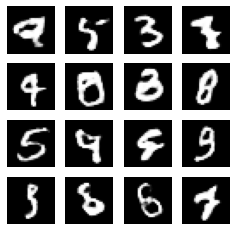

Evaluating:
Epoch  28 0.5824999868869781 4.5311154174804695


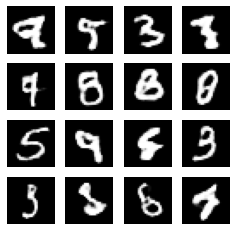

Evaluating:
Epoch  29 0.8066666722297668 3.350115712483724


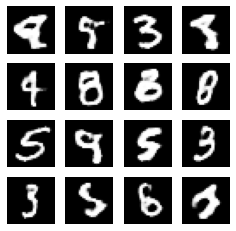

Evaluating:
Epoch  30 0.5666666686534881 5.6237022399902346


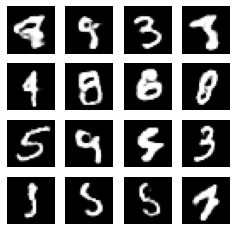

Evaluating:
Epoch  31 0.6599999964237213 4.581646067301433


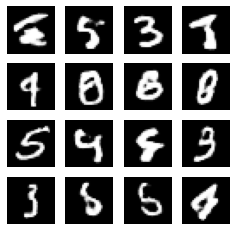

Evaluating:
Epoch  32 0.5308333337306976 7.126181030273438


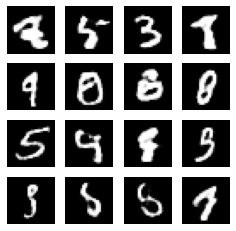

Evaluating:
Epoch  33 0.6508333325386048 5.4512015787760415


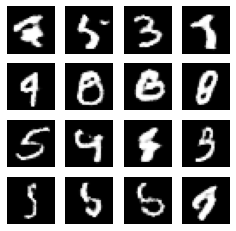

Evaluating:
Epoch  34 0.8900000095367432 1.6787453333536781


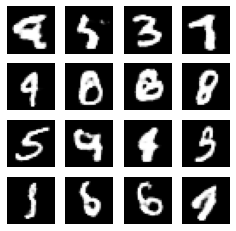

Evaluating:
Epoch  35 0.8808333277702332 2.6643200683593755


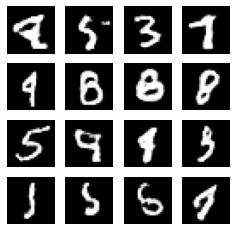

Evaluating:
Epoch  36 0.8800000011920929 2.1848032887776694


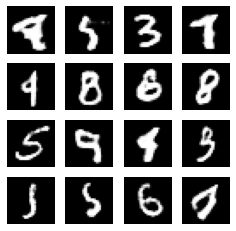

Evaluating:
Epoch  37 0.6899999976158142 5.070362497965495


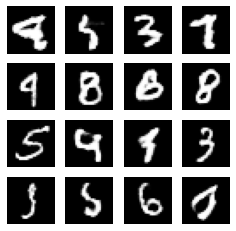

Evaluating:
Epoch  38 0.6149999976158143 5.5541603597005205


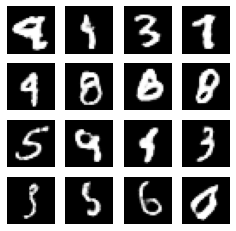

Evaluating:
Epoch  39 0.6925000011920929 0.7998797861735026


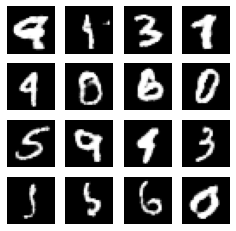

Evaluating:
Epoch  40 0.6441666662693024 5.154272766113281


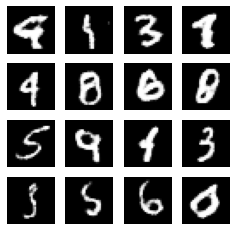

Evaluating:
Epoch  41 0.598333328962326 5.9807672119140625


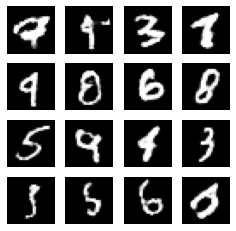

Evaluating:
Epoch  42 0.6558333337306976 5.200018971761068


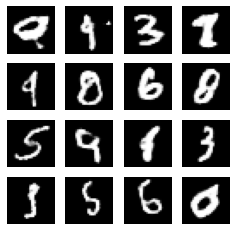

Evaluating:
Epoch  43 0.9058333396911621 3.0881948852539063


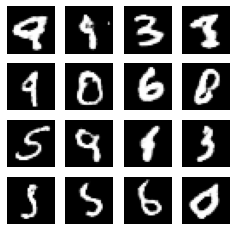

Evaluating:
Epoch  44 0.7583333313465118 0.8910874684651693


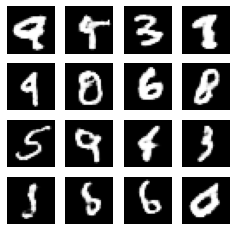

Evaluating:
Epoch  45 0.676666659116745 4.678278961181641


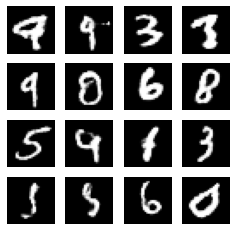

Evaluating:
Epoch  46 0.8441666662693024 3.4839084625244148


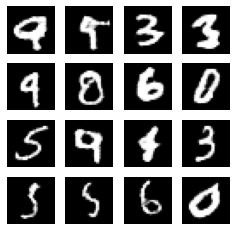

Evaluating:
Epoch  47 0.7008333325386047 0.8444836171468099


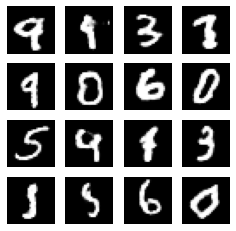

Evaluating:
Epoch  48 0.7541666626930237 0.9502089627583823


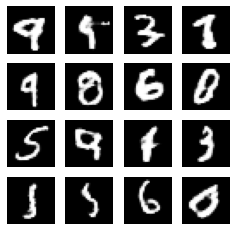

Evaluating:
Epoch  49 0.6891666710376739 0.651909392674764


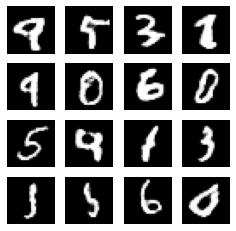

Evaluating:
Epoch  50 0.6300000131130219 7.090900573730468


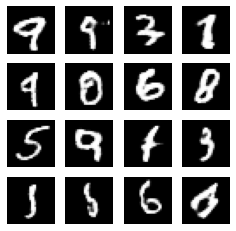

Evaluating:
Epoch  51 0.860833328962326 1.4848604075113934


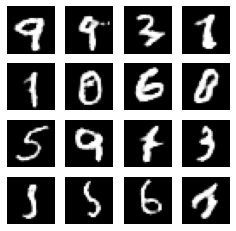

Evaluating:
Epoch  52 0.9133333325386047 2.5418519337972003


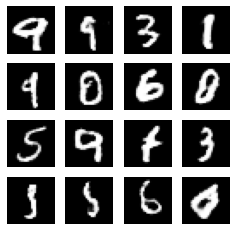

Evaluating:
Epoch  53 0.6599999904632569 0.6660671869913737


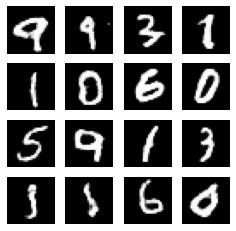

Evaluating:
Epoch  54 0.9124999940395355 2.1961310323079424


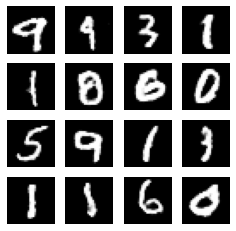

Evaluating:
Epoch  55 0.9308333396911621 2.3867978413899733


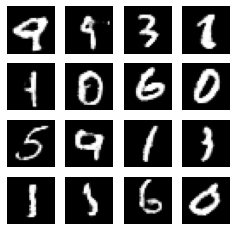

Evaluating:
Epoch  56 0.7966666698455811 1.2211195182800292


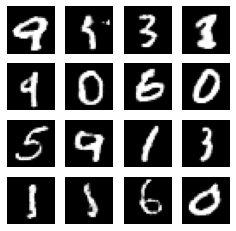

Evaluating:
Epoch  57 0.5258333325386048 9.448562520345053


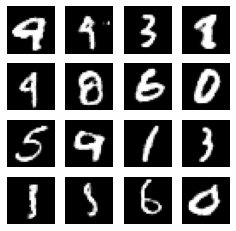

Evaluating:
Epoch  58 0.8974999964237214 3.4596276092529292


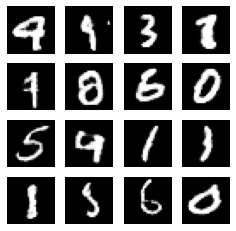

Evaluating:
Epoch  59 0.8399999976158142 4.395164616902669


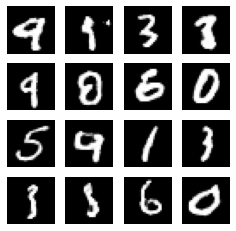

Evaluating:
Epoch  60 0.8875 3.109332555135091


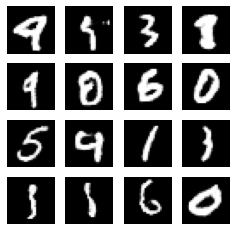

Evaluating:
Epoch  61 0.8875000059604645 3.154205958048503


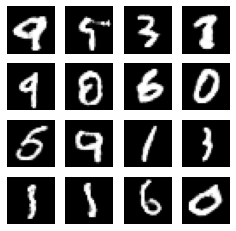

Evaluating:
Epoch  62 0.8933333337306977 2.341862665812175


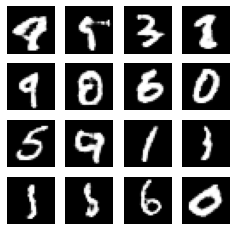

Evaluating:
Epoch  63 0.6158333241939544 7.6899711100260415


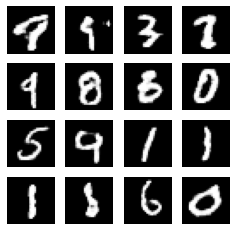

Evaluating:
Epoch  64 0.8550000011920929 4.383955510457357


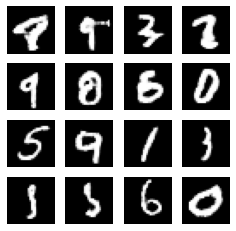

Evaluating:
Epoch  65 0.710833340883255 6.901170399983724


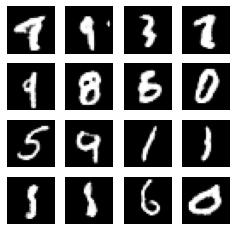

Evaluating:
Epoch  66 0.9116666615009308 2.396336008707682


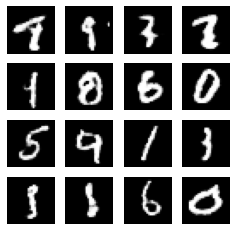

Evaluating:
Epoch  67 0.9291666686534882 2.4015234883626304


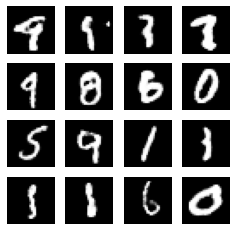

Evaluating:
Epoch  68 0.8500000059604644 1.5104892094930014


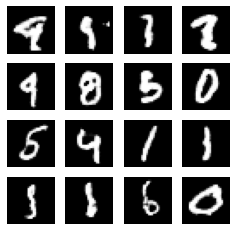

Evaluating:
Epoch  69 0.8475000023841858 1.7461936442057293


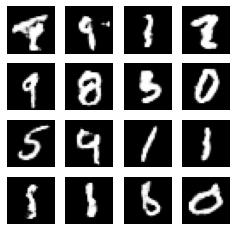

Evaluating:
Epoch  70 0.8724999964237213 1.5618113199869792


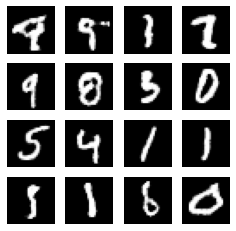

Evaluating:
Epoch  71 0.7225000083446502 0.8389929962158205


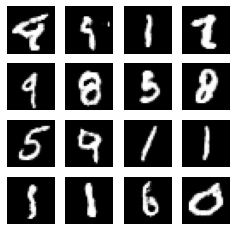

Evaluating:
Epoch  72 0.9300000071525574 3.6020404052734376


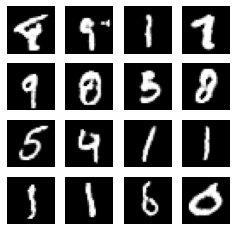

Evaluating:
Epoch  73 0.7216666638851166 6.970587158203125


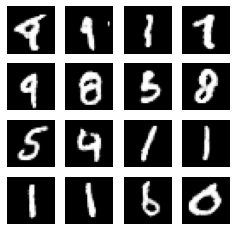

Evaluating:
Epoch  74 0.5733333349227905 0.2555909601847331


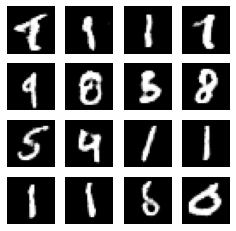

Evaluating:
Epoch  75 0.9224999964237213 4.145051701863607


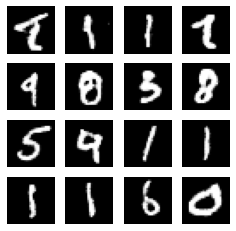

Evaluating:
Epoch  76 0.9308333396911621 3.687218322753907


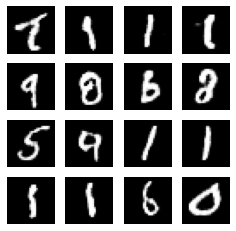

Evaluating:
Epoch  77 0.9133333444595337 3.4349316151936855


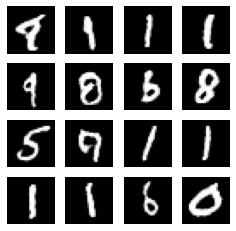

Evaluating:
Epoch  78 0.6724999904632568 9.394208882649739


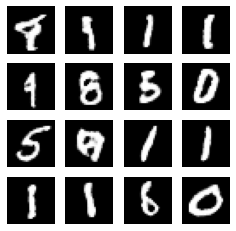

Evaluating:
Epoch  79 0.6433333277702331 0.4909119764963785


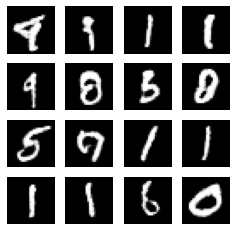

Evaluating:
Epoch  80 0.5708333373069763 9.773807881673177


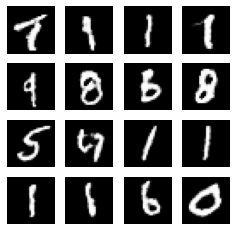

Evaluating:
Epoch  81 0.5158333241939544 12.543911031087239


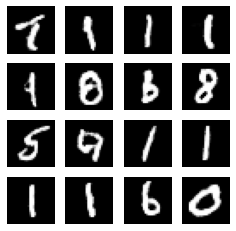

Evaluating:
Epoch  82 0.5208333313465119 0.07754026492436727


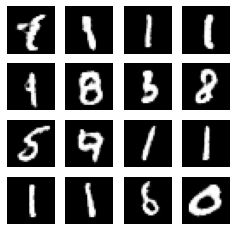

Evaluating:
Epoch  83 0.5433333337306976 12.58945048014323


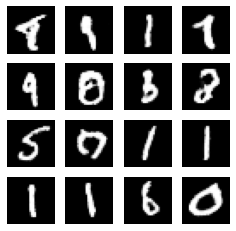

Evaluating:
Epoch  84 0.5291666507720947 12.639023234049478


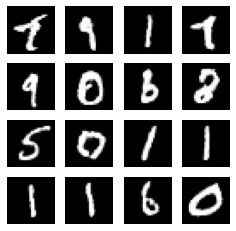

Evaluating:
Epoch  85 0.9016666650772095 2.8310232289632156


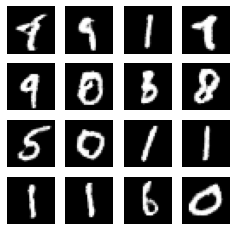

Evaluating:
Epoch  86 0.5741666674613952 0.249253347714742


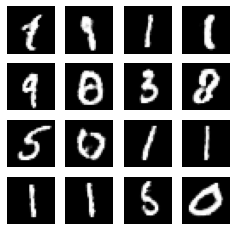

Evaluating:
Epoch  87 0.5808333396911621 11.125373840332031


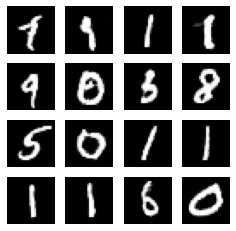

Evaluating:
Epoch  88 0.7116666615009308 0.8088646825154623


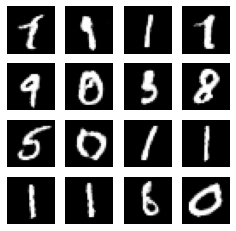

Evaluating:
Epoch  89 0.9041666746139526 5.161734364827474


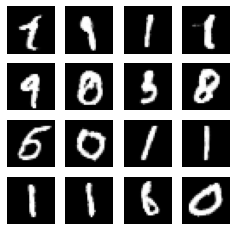

Evaluating:
Epoch  90 0.95333331823349 3.378111775716146


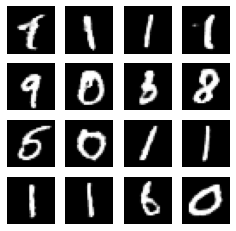

Evaluating:
Epoch  91 0.9349999964237213 3.399494425455729


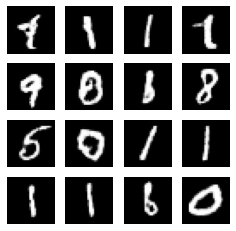

Evaluating:
Epoch  92 0.8333333373069763 1.4184667841593426


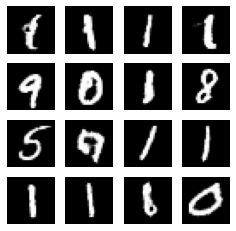

Evaluating:
Epoch  93 0.7724999964237214 1.3658389536539712


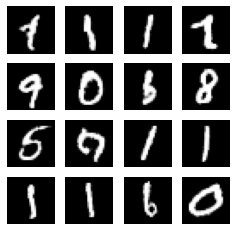

Evaluating:
Epoch  94 0.5749999940395355 11.364389139811198


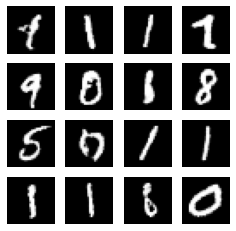

Evaluating:
Epoch  95 0.9391666650772095 3.763685709635417


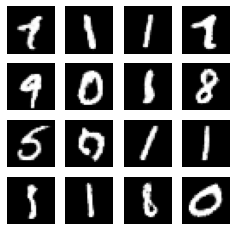

Evaluating:
Epoch  96 0.5108333230018616 0.04258932113647461


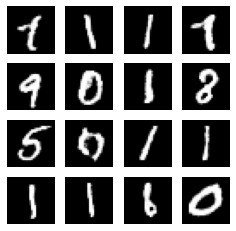

Evaluating:
Epoch  97 0.7216666638851166 0.9042361704508464


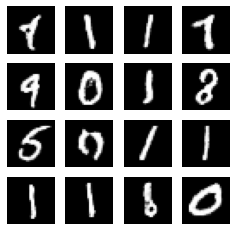

Evaluating:
Epoch  98 0.9449999928474426 3.433265202840169


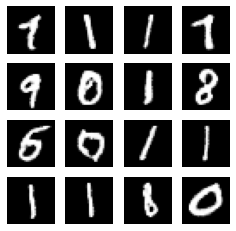

Evaluating:
Epoch  99 0.5416666626930237 14.372462361653643


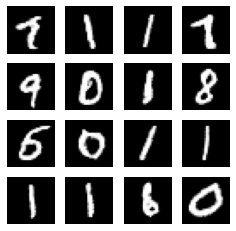

In [ ]:
trainGan(cx_train, cy_train, epochs=100, batch_size=60, smooth=1)

(500, 120, 28, 28, 1)
Evaluating:
Epoch  0 0.9545833230018616 0.024738627076148986


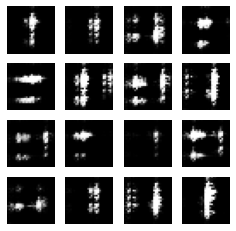

Evaluating:
Epoch  1 0.956250011920929 0.023567277987798053


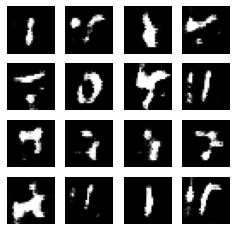

Evaluating:
Epoch  2 0.9233333349227906 0.02405080179373423


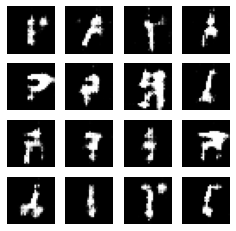

Evaluating:
Epoch  3 0.8625 0.03363981246948242


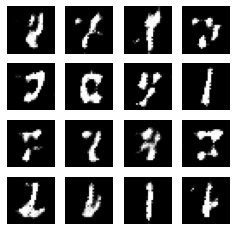

Evaluating:
Epoch  4 0.8354166686534882 0.02609518607457479


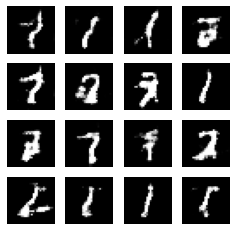

Evaluating:
Epoch  5 0.8500000059604644 0.028328500390052795


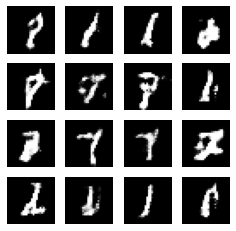

Evaluating:
Epoch  6 0.885833328962326 0.018460679550965624


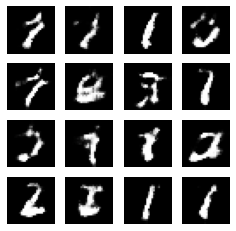

Evaluating:
Epoch  7 0.8591666638851165 0.015273528893788657


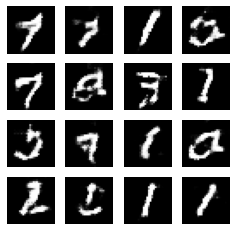

Evaluating:
Epoch  8 0.7737499952316285 0.0077253489693005885


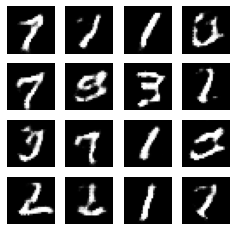

Evaluating:
Epoch  9 0.8691666662693024 0.014661802351474759


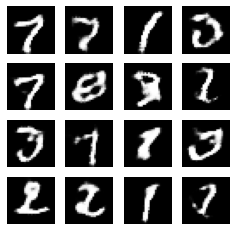

Evaluating:
Epoch  10 0.8179166674613952 0.01902062257130941


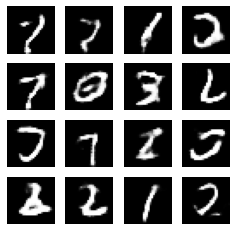

Evaluating:
Epoch  11 0.7416666686534882 0.02194464027881622


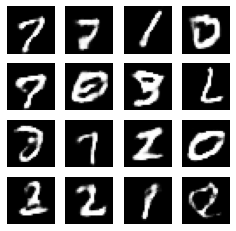

Evaluating:
Epoch  12 0.7662500023841858 0.008019853830337525


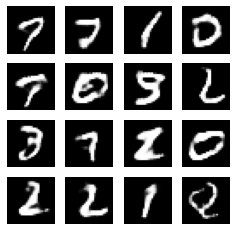

Evaluating:
Epoch  13 0.7545833349227905 0.007001283218463261


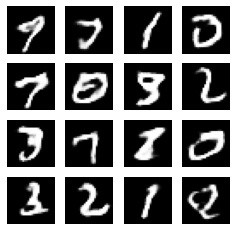

Evaluating:
Epoch  14 0.851666659116745 0.008847016245126724


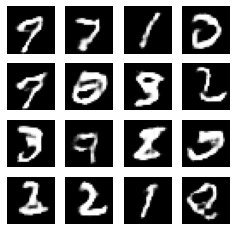

Evaluating:
Epoch  15 0.7058333277702331 0.018593556880950927


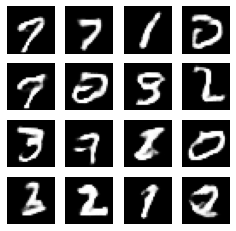

Evaluating:
Epoch  16 0.7970833361148835 0.014798387289047244


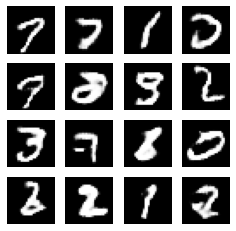

Evaluating:
Epoch  17 0.6704166650772094 0.021932384570439657


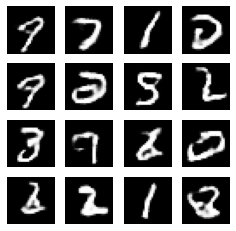

Evaluating:
Epoch  18 0.8399999976158142 0.008982605238755544


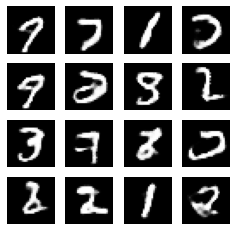

Evaluating:
Epoch  19 0.7350000023841858 0.005174760421117147


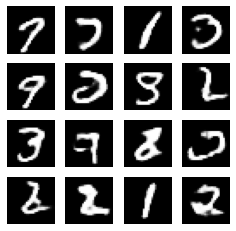

Evaluating:
Epoch  20 0.8225000143051148 0.009077883809804916


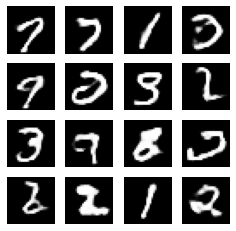

Evaluating:
Epoch  21 0.5229166626930237 0.03469657977422079


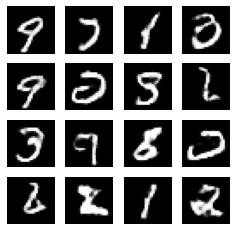

Evaluating:
Epoch  22 0.7858333349227905 0.00770848015944163


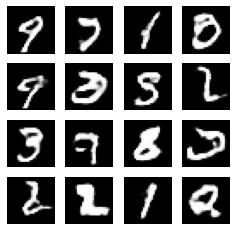

Evaluating:
Epoch  23 0.7195833325386047 0.01560828487078349


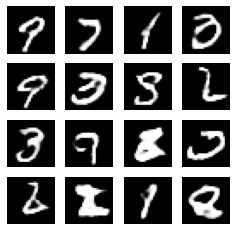

Evaluating:
Epoch  24 0.6116666674613953 0.023767237067222592


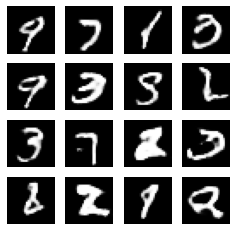

Evaluating:
Epoch  25 0.7879166603088379 0.01404127101103465


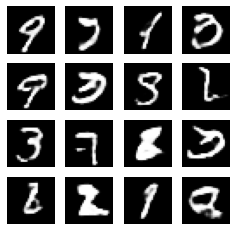

Evaluating:
Epoch  26 0.5475000083446503 0.03055066168308258


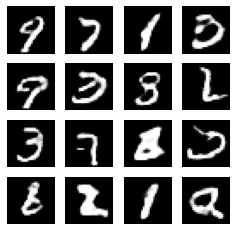

Evaluating:
Epoch  27 0.7783333361148834 0.015371184448401132


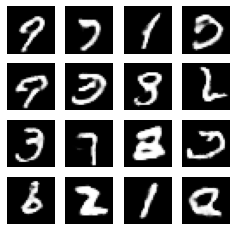

Evaluating:
Epoch  28 0.7004166662693023 0.005261144489049911


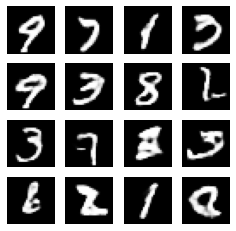

Evaluating:
Epoch  29 0.6320833265781403 0.023134596149126687


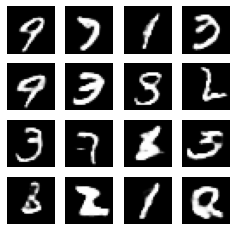

Evaluating:
Epoch  30 0.5416666686534881 0.032859913508097326


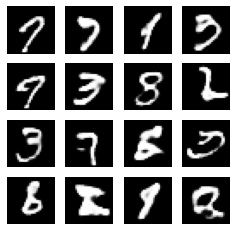

Evaluating:
Epoch  31 0.7987499952316284 0.008792902380228044


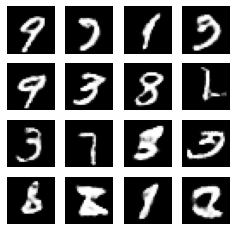

Evaluating:
Epoch  32 0.5183333218097687 0.038493369817733755


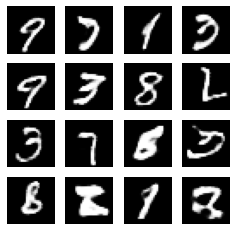

Evaluating:
Epoch  33 0.8487500131130219 0.017797292768955232


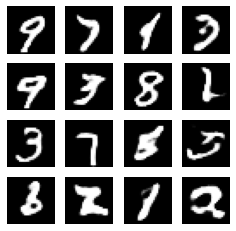

Evaluating:
Epoch  34 0.826666659116745 0.012884178658326468


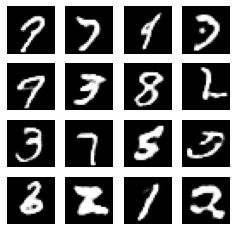

Evaluating:
Epoch  35 0.6037499964237213 0.02907566368579864


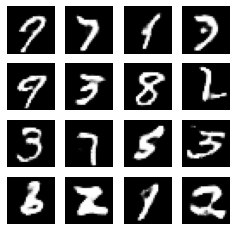

Evaluating:
Epoch  36 0.575 0.0022717352459828057


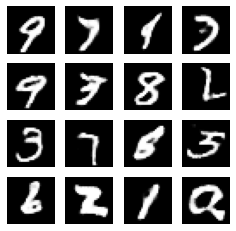

Evaluating:
Epoch  37 0.75 0.006269047260284423


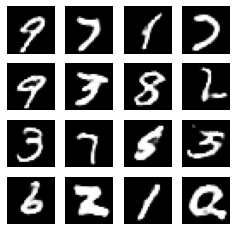

Evaluating:
Epoch  38 0.8004166662693024 0.009715684851010641


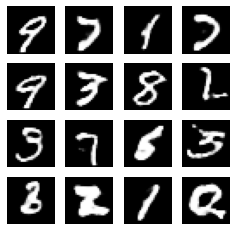

Evaluating:
Epoch  39 0.8845833241939545 0.01642599016427994


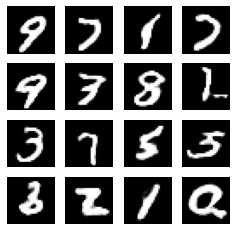

Evaluating:
Epoch  40 0.809583330154419 0.011123184661070505


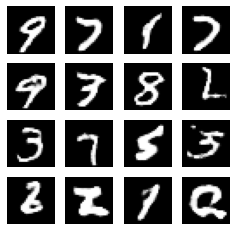

Evaluating:
Epoch  41 0.7970833301544189 0.01146220008532206


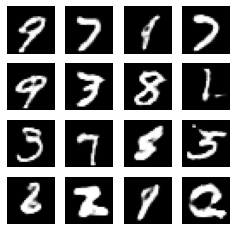

Evaluating:
Epoch  42 0.7270833313465118 0.020556619167327882


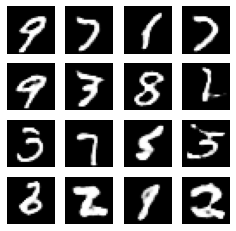

Evaluating:
Epoch  43 0.729583340883255 0.021497877240180967


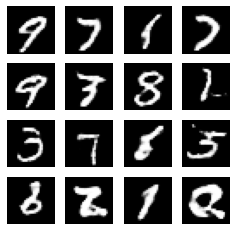

Evaluating:
Epoch  44 0.8412500083446502 0.009418118596076965


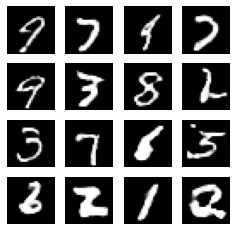

Evaluating:
Epoch  45 0.7091666638851166 0.03354032774766286


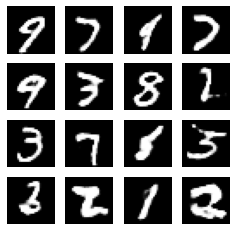

Evaluating:
Epoch  46 0.8045833349227905 0.008028189092874527


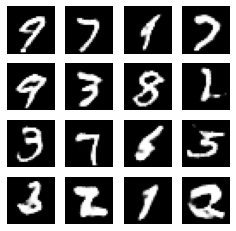

Evaluating:
Epoch  47 0.5945833325386047 0.03317287504673004


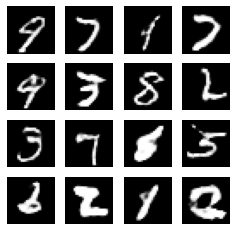

Evaluating:
Epoch  48 0.7995833337306977 0.017194011608759562


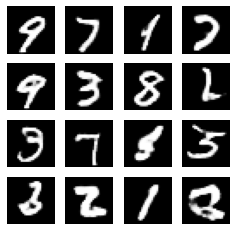

Evaluating:
Epoch  49 0.8120833218097687 0.018038142522176108


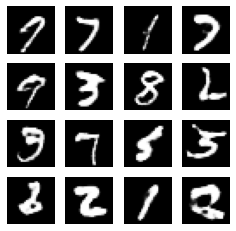

Evaluating:
Epoch  50 0.6112500071525574 0.02826188802719116


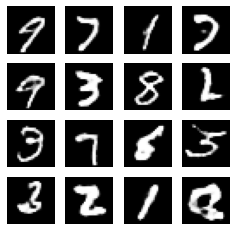

Evaluating:
Epoch  51 0.8754166662693024 0.012601522107919058


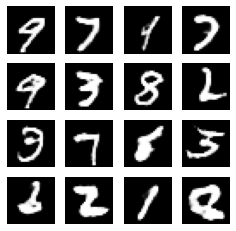

Evaluating:
Epoch  52 0.8274999916553497 0.010715135435263316


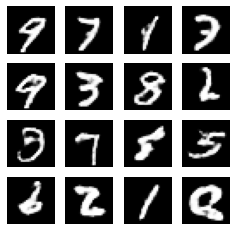

Evaluating:
Epoch  53 0.6383333206176758 0.028852999607721964


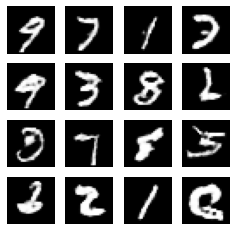

Evaluating:
Epoch  54 0.8758333325386047 0.01525037070115407


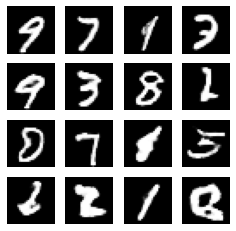

Evaluating:
Epoch  55 0.7712499976158143 0.009904576341311137


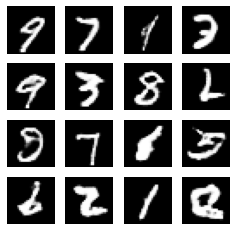

Evaluating:
Epoch  56 0.8604166746139527 0.014895711839199067


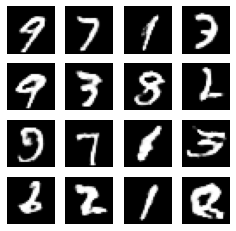

Evaluating:
Epoch  57 0.6979166567325592 0.028243312637011207


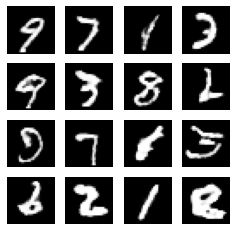

Evaluating:
Epoch  58 0.8095833241939545 0.009429227610429127


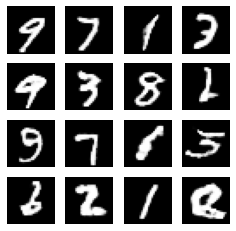

Evaluating:
Epoch  59 0.8995833337306977 0.015508604149023691


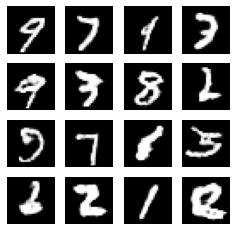

Evaluating:
Epoch  60 0.6887499928474426 0.03350888172785441


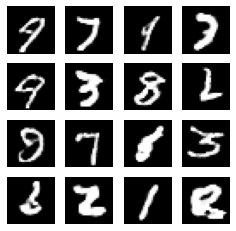

Evaluating:
Epoch  61 0.8504166662693023 0.019832313855489093


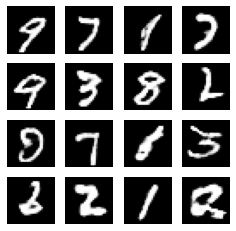

Evaluating:
Epoch  62 0.8625 0.018265267809232075


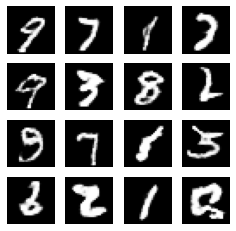

Evaluating:
Epoch  63 0.7429166734218597 0.006120191862185796


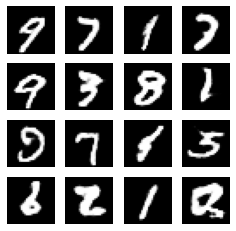

Evaluating:
Epoch  64 0.5487500071525574 0.04982897837956747


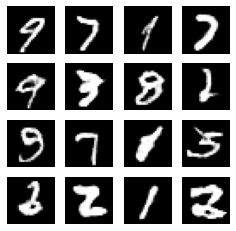

Evaluating:
Epoch  65 0.5191666603088378 0.0006536202815671762


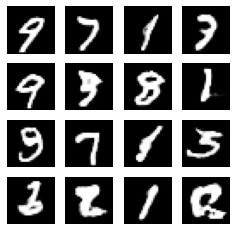

Evaluating:
Epoch  66 0.8025000035762787 0.008590310513973236


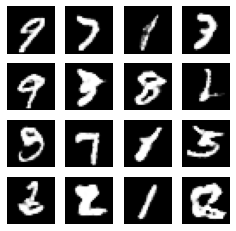

Evaluating:
Epoch  67 0.6870833396911621 0.03386259814103444


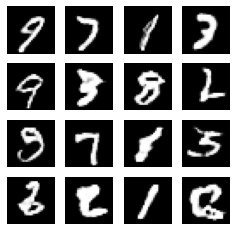

Evaluating:
Epoch  68 0.7866666555404663 0.03163525144259135


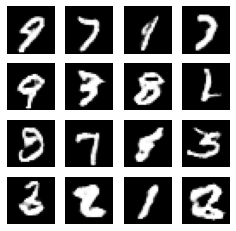

Evaluating:
Epoch  69 0.8683333337306977 0.012102939188480377


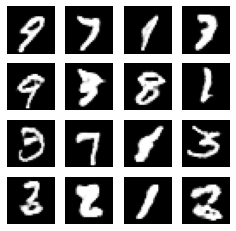

Evaluating:
Epoch  70 0.5366666615009308 0.054118695656458535


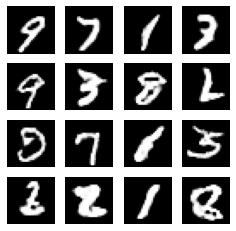

Evaluating:
Epoch  71 0.5404166638851166 0.05709866801897684


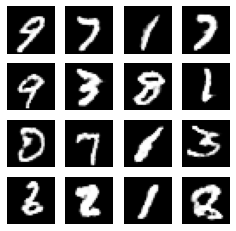

Evaluating:
Epoch  72 0.6666666626930237 0.038512401978174834


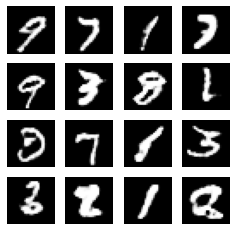

Evaluating:
Epoch  73 0.7970833480358124 0.009293206930160522


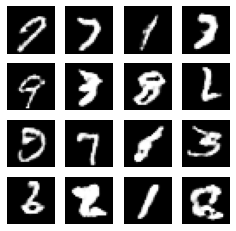

Evaluating:
Epoch  74 0.7495833396911621 0.03083189090092977


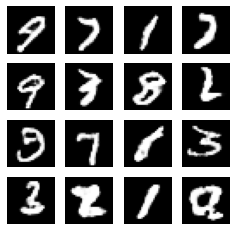

Evaluating:
Epoch  75 0.5524999976158143 0.0559648851553599


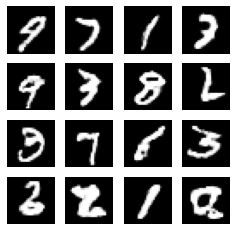

Evaluating:
Epoch  76 0.9029166638851166 0.019787970383961996


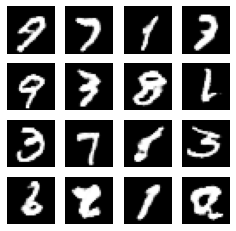

Evaluating:
Epoch  77 0.6616666674613952 0.0040835616985956825


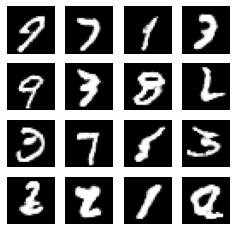

Evaluating:
Epoch  78 0.8129166662693024 0.009171804289023082


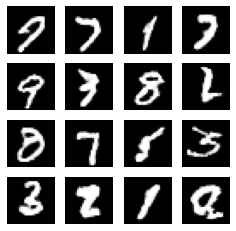

Evaluating:
Epoch  79 0.882916659116745 0.012476657032966614


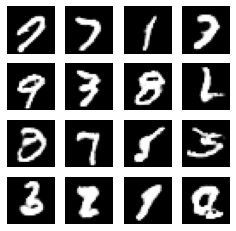

Evaluating:
Epoch  80 0.8195833384990692 0.026247153878211978


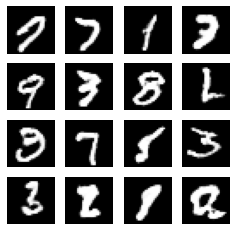

Evaluating:
Epoch  81 0.9254166722297669 0.023723194599151613


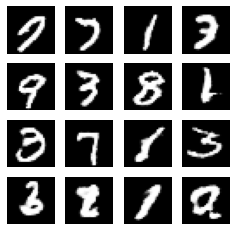

Evaluating:
Epoch  82 0.7379166781902313 0.033352181315422065


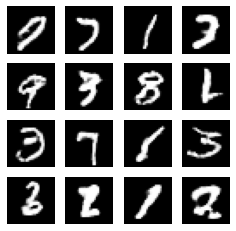

Evaluating:
Epoch  83 0.9195833384990693 0.022264127333958945


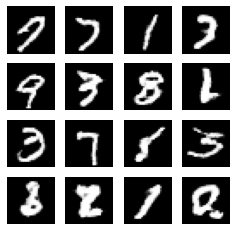

Evaluating:
Epoch  84 0.8208333313465118 0.00936497171719869


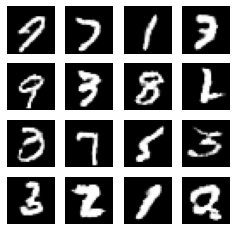

Evaluating:
Epoch  85 0.8054166615009308 0.00842808316151301


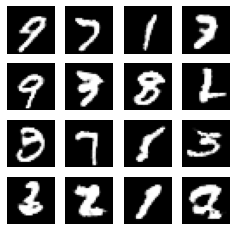

Evaluating:
Epoch  86 0.8691666662693024 0.02381949782371521


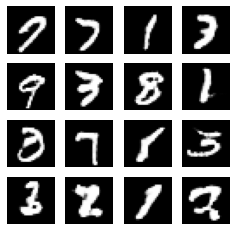

Evaluating:
Epoch  87 0.8150000035762787 0.03112142026424407


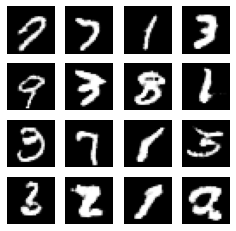

Evaluating:
Epoch  88 0.7870833337306976 0.03591895262400309


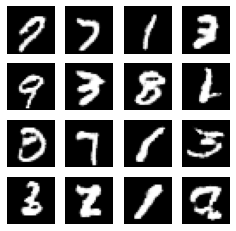

Evaluating:
Epoch  89 0.9100000023841858 0.02188535670439402


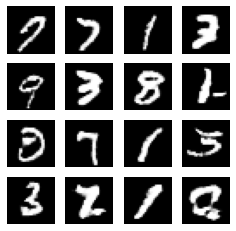

Evaluating:
Epoch  90 0.6775000035762787 0.004477650473515192


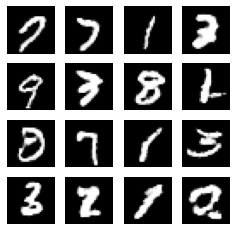

Evaluating:
Epoch  91 0.5483333468437195 0.0014001669734716416


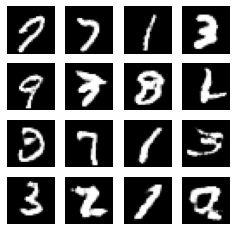

Evaluating:
Epoch  92 0.7837500095367431 0.007306215713421505


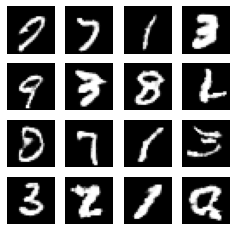

Evaluating:
Epoch  93 0.7512499988079071 0.0071875869234402975


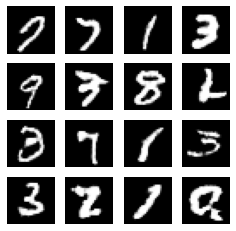

Evaluating:
Epoch  94 0.9258333384990692 0.017006685336430866


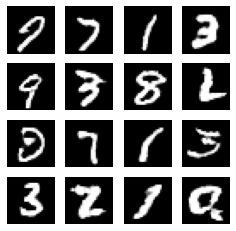

Evaluating:
Epoch  95 0.8112499952316284 0.03688548167546591


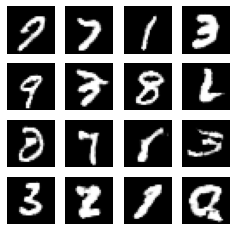

Evaluating:
Epoch  96 0.9062499940395355 0.025718550284703573


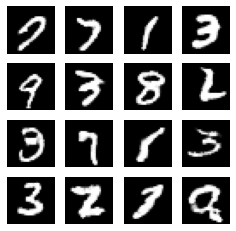

Evaluating:
Epoch  97 0.717083340883255 0.042689945697784414


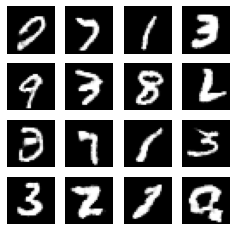

Evaluating:
Epoch  98 0.6479166567325592 0.0037879551698764163


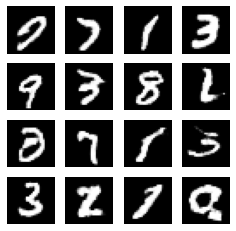

Evaluating:
Epoch  99 0.7500000059604645 0.03863197008768717


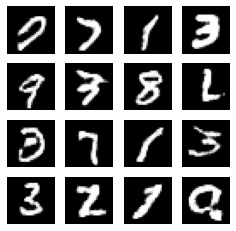

In [ ]:
trainGan(cx_train, cy_train, epochs=100, batch_size=60, smooth=1)